In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import random
import matplotlib.pyplot as plt

In [10]:
row_count = 0.25
col_count = 1
a = 0.05
sheetSize = 200
m = 1
n = 1

In [8]:
initial_points = []
for i in range(1,row_count):
    for j in range(1,col_count):
        initial_points.append([i,j])

In [12]:
initial_points = []
for i in range(1,int(row_count//a+1)):  
    for j in range(1,int(col_count//a+1)):
        initial_points.append([m*a/2,n*a/2])
        n=n+2
    n=1    
    m=m+2


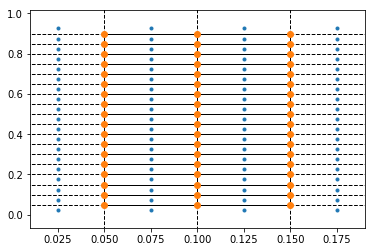

In [13]:
vor = Voronoi(initial_points, qhull_options='Qbb Qc Qx')
voronoi_plot_2d(vor)
plt.show()

In [59]:
final_points = []
for i in initial_points:
        x,y = i
        random_num = random.uniform(-1.0, 1.0)
        x = x + ((random_num * a) / 2)
        y = y + ((random_num * a) / 2)
        final_points.append([x,y])

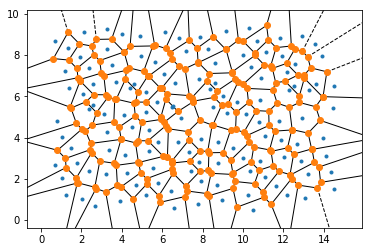

In [60]:
vor = Voronoi(final_points, qhull_options='Qbb Qc Qx')
voronoi_plot_2d(vor)
plt.show()

In [61]:
line_scripts = ""

for vpair in vor.ridge_vertices:
    if vpair[0] >= 0 and vpair[1] >= 0:
        v0 = vor.vertices[vpair[0]]
        v1 = vor.vertices[vpair[1]]
        line_scripts = line_scripts + "s1.Line(point1=([" + str(v0[0]) + "," + str(v0[1]) + "]), point2=([" + str(v1[0]) + "," + str(v1[1]) + "]))\n"


In [62]:
var_to_inject = {'col': col_count, 'row': row_count, 'sheetSize': sheetSize, 'line_scripts': line_scripts}

In [63]:
code = '''
# -*- coding: mbcs -*-
# Do not delete the following import lines
from abaqus import *
from abaqusConstants import *
import __main__

import section
import regionToolset
import displayGroupMdbToolset as dgm
import part
import material
import assembly
import step
import interaction
import load
import mesh
import optimization
import job
import sketch
import visualization
import xyPlot
import displayGroupOdbToolset as dgo
import connectorBehavior
s = mdb.models['Model-1'].ConstrainedSketch(name='__profile__',
                                            sheetSize={sheetSize})
g, v, d, c = s.geometry, s.vertices, s.dimensions, s.constraints
s.setPrimaryObject(option=STANDALONE)
s.rectangle(point1=(0.0, 0.0), point2=({row}, {col}))
p = mdb.models['Model-1'].Part(name='Part-1', dimensionality=TWO_D_PLANAR,
                               type=DEFORMABLE_BODY)
p = mdb.models['Model-1'].parts['Part-1']
p.BaseShell(sketch=s)
s.unsetPrimaryObject()
p = mdb.models['Model-1'].parts['Part-1']
session.viewports['Viewport: 1'].setValues(displayedObject=p)
del mdb.models['Model-1'].sketches['__profile__']
p = mdb.models['Model-1'].parts['Part-1']
f, e, d1 = p.faces, p.edges, p.datums
t = p.MakeSketchTransform(sketchPlane=f[0], sketchPlaneSide=SIDE1, origin=(
    0.0, 0.0, 0.0))
s1 = mdb.models['Model-1'].ConstrainedSketch(name='__profile__',
                                             sheetSize={sheetSize}, gridSpacing=2, transform=t)
g, v, d, c = s1.geometry, s1.vertices, s1.dimensions, s1.constraints
s1.setPrimaryObject(option=SUPERIMPOSE)
p = mdb.models['Model-1'].parts['Part-1']
p.projectReferencesOntoSketch(sketch=s1, filter=COPLANAR_EDGES)
{line_scripts}
p = mdb.models['Model-1'].parts['Part-1']
f = p.faces
pickedFaces = f.getSequenceFromMask(mask=('[#1 ]', ), )
e1, d2 = p.edges, p.datums
p.PartitionFaceBySketch(faces=pickedFaces, sketch=s1)
s1.unsetPrimaryObject()
del mdb.models['Model-1'].sketches['__profile__']

'''

In [64]:
content = code.format(**var_to_inject)
with open("script.py", "w") as code_file:
    print(content, file=code_file)